In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
path1 = "/Users/laurasuemitsu/Desktop/DATA_FT_May_2025/Week 5/Project/CSV files/df_final_web_data_merged.csv"

In [61]:
df1 = pd.read_csv(path1)

In [62]:
path2 = "/Users/laurasuemitsu/Desktop/DATA_FT_May_2025/Week 5/Project/CSV files/df_final_experiment_clients.csv"

In [63]:
df2 = pd.read_csv(path2)
df2.drop(columns=("Unnamed: 0"), inplace=True)

In [64]:
df_merged = df1.merge(df2, how="inner", on="client_id")
df_merged.dropna(inplace=True)

In [65]:
df_merged.shape

(321309, 6)

In [166]:
df_merged.head()

,client_id,visitor_id,visit_id,process_step,date_time,Variation,step_num,step_diff,is_error
70803,555,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,Test,1,NaN,False
70802,555,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,Test,2,1.0,False
70801,555,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,Test,3,1.0,False
70800,555,402506806_56087378777,637149525_38041617439_716659,step_3,2017-04-15 13:00:14,Test,4,1.0,False
70799,555,402506806_56087378777,637149525_38041617439_716659,confirm,2017-04-15 13:00:34,Test,5,1.0,False


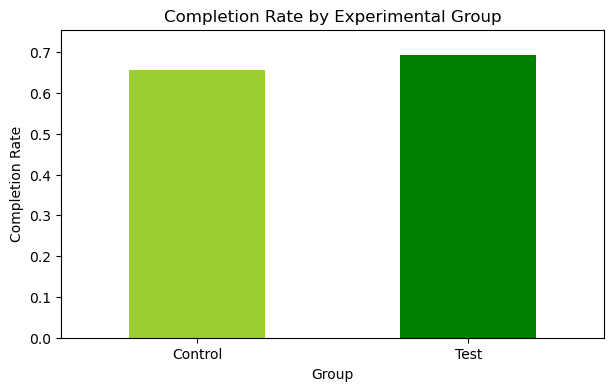

In [141]:
completion_df = df_merged[df_merged["process_step"] == "confirm"]
completion_rate = completion_df.groupby("Variation")["client_id"].nunique() / df_merged.groupby("Variation")["client_id"].nunique()

# Drawing the plot
plt.figure(figsize=(7, 4))
bars = completion_rate.plot(kind='bar', color=["yellowgreen", "green"])

# Formating
plt.title("Completion Rate by Experimental Group")
plt.ylabel("Completion Rate")
plt.xlabel("Group")
plt.ylim(0, 1.09 * completion_rate.max())
plt.xticks(rotation=0)



plt.show()

**H0:** mu completion rate test = completion rate control

**H1:** mu completion rate test != completion rate control

In [67]:
from statsmodels.stats.proportion import proportions_ztest

In [68]:
completion_df

,client_id,visitor_id,visit_id,process_step,date_time,Variation
8,8320017,39393514_33118319366,960651974_70596002104_312201,confirm,2017-04-05 13:10:05,Test
13,4033851,762728880_76361333336,949661017_22392791362_127391,confirm,2017-04-05 12:29:03,Control
14,4033851,762728880_76361333336,949661017_22392791362_127391,confirm,2017-04-05 12:29:01,Control
15,4033851,762728880_76361333336,949661017_22392791362_127391,confirm,2017-04-05 12:28:52,Control
24,1982004,618934751_10082078917,132494692_73738638511_70823,confirm,2017-04-17 12:02:42,Test
...,...,...,...,...,...,...
417623,6230585,100189756_32488226026,671811152_97876326241_999687,confirm,2017-05-08 09:29:38,Test
417628,4977550,795300798_27713164444,423005536_66563748376_701196,confirm,2017-05-25 15:19:39,Control
417634,6426623,27047012_3402532492,685634090_42070675506_389171,confirm,2017-05-19 05:40:14,Control
417639,433098,5505424_50616523266,773565250_67577573147_389841,confirm,2017-05-13 15:33:04,Control


In [69]:
successes_df = completion_df.groupby("Variation")["client_id"].nunique()
successes_df.head()

Variation
Control    15434
Test       18687
Name: client_id, dtype: int64

In [70]:
successes = [successes_df["Test"], successes_df["Control"]]


In [71]:
tries_df = df_merged.groupby("Variation")["client_id"].nunique()

In [72]:
tries = [tries_df["Test"], tries_df["Control"]]

In [73]:
proportions_ztest(successes, tries)

(8.8745141890702, 7.023933247581432e-19)

In [90]:

df_merged["date_time"] = pd.to_datetime(df_merged["date_time"])

# -> Calculate total journey duration per user
# Group by client_id and group, and calculate the min and max datetime
duration_df = df_merged.groupby(["client_id", "Variation"])["date_time"].agg(["min", "max"])

# Calculate journey duration in seconds
duration_df["duration_sec"] = (duration_df["max"] - duration_df["min"]).dt.total_seconds()

# Sort by duration
duration_df.sort_values(by=["duration_sec"])

# Remove zeros
clean_duration_df = duration_df[duration_df["duration_sec"] > 0]

# Division into test and control groups
test_durations = clean_duration_df[clean_duration_df.index.get_level_values("Variation") == "Test"]["duration_sec"]

control_durations = clean_duration_df[clean_duration_df.index.get_level_values("Variation") == "Control"]["duration_sec"]

print(test_durations.head(10))
print(" ")
print(control_durations.head(10))

# T-test code
from scipy.stats import ttest_ind

stat, pval = ttest_ind(test_durations, control_durations, nan_policy='omit')

print(f"\n⏱️ T-test on journey duration:\nStat = {stat:.3f}, p-value = {pval:.2e}")

client_id  Variation
555        Test             158.0
647        Test             377.0
934        Test             142.0
1336       Test            8268.0
1346       Test             495.0
1516       Test          110207.0
1643       Test         4812895.0
1702       Test         6127401.0
1755       Test          329392.0
1836       Test          139707.0
Name: duration_sec, dtype: float64
 
client_id  Variation
1028       Control          538.0
1104       Control       744135.0
1186       Control         7568.0
1195       Control          245.0
1197       Control           95.0
3647       Control      4505594.0
3743       Control          292.0
5354       Control        85958.0
6642       Control          443.0
6977       Control          227.0
Name: duration_sec, dtype: float64

⏱️ T-test on journey duration:
Stat = -4.783, p-value = 1.73e-06


In [101]:
clean_duration_df.head()

,,min,max,duration_sec
client_id,Variation,,,
555,Test,2017-04-15 12:57:56,2017-04-15 13:00:34,158.0
647,Test,2017-04-12 15:41:28,2017-04-12 15:47:45,377.0
934,Test,2017-04-18 02:36:30,2017-04-18 02:38:52,142.0
1028,Control,2017-04-08 18:51:28,2017-04-08 19:00:26,538.0
1104,Control,2017-06-12 07:49:18,2017-06-20 22:31:33,744135.0


In [114]:
duration_bar_chart = clean_duration_df.drop(columns=["min", "max"])
duration_bar_chart.head()

,,duration_sec
client_id,Variation,
555,Test,158.0
647,Test,377.0
934,Test,142.0
1028,Control,538.0
1104,Control,744135.0


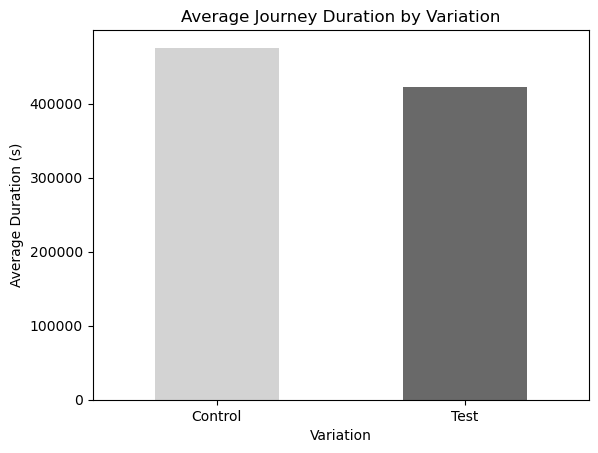

In [123]:
# Group by Variation and calculate the average duration
avg_duration = duration_bar_chart.groupby('Variation')['duration_sec'].mean()

# Plot the data
avg_duration.plot(kind='bar', color=['lightgrey', 'dimgrey'])  # Color can be customized
plt.title('Average Journey Duration by Variation')
plt.xlabel('Variation')
plt.ylabel('Average Duration (s)')
plt.xticks(rotation=0)
plt.show()

In [145]:
step_order = {'start': 1, 'step_1': 2, 'step_2': 3, 'step_3': 4, 'confirm': 5}
df_merged['step_num'] = df_merged['process_step'].map(step_order)
df_merged.head()

,client_id,visitor_id,visit_id,process_step,date_time,Variation,step_num
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,4
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,3
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,4
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,3
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,4


In [147]:
df_merged = df_merged.sort_values(by=['client_id', 'date_time'])
df_merged.head(3)

,client_id,visitor_id,visit_id,process_step,date_time,Variation,step_num
70803,555,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,Test,1
70802,555,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,Test,2
70801,555,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,Test,3


In [157]:
df_merged['step_diff'] = df_merged.groupby('client_id')['step_num'].diff()

df_merged['is_error'] = df_merged['step_diff'] < 0

df_merged.head()

,client_id,visitor_id,visit_id,process_step,date_time,Variation,step_num,step_diff,is_error
70803,555,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,Test,1,NaN,False
70802,555,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,Test,2,1.0,False
70801,555,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,Test,3,1.0,False
70800,555,402506806_56087378777,637149525_38041617439_716659,step_3,2017-04-15 13:00:14,Test,4,1.0,False
70799,555,402506806_56087378777,637149525_38041617439_716659,confirm,2017-04-15 13:00:34,Test,5,1.0,False


In [158]:
# Calculate error rate per group
error_counts = df_merged.groupby('Variation')['is_error'].sum()
total_transitions = df_merged.groupby('Variation')['step_diff'].count()
error_rate = round((error_counts / total_transitions) * 100, 2)

In [159]:
error_rate.head()

Variation
Control    11.12
Test       12.65
dtype: float64

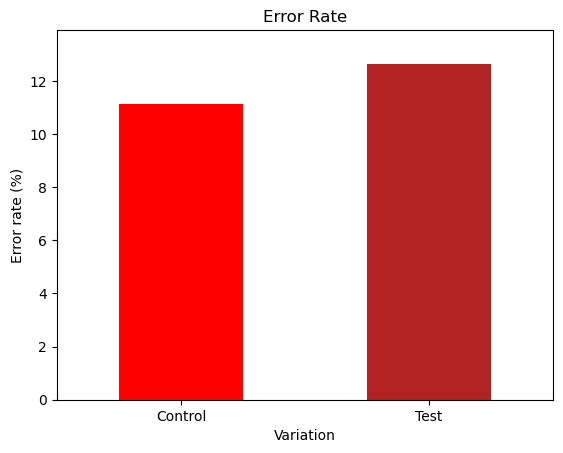

In [165]:
# Plot the data
error_rate.plot(kind='bar', color=['red', 'firebrick'])
plt.title('Error Rate')
plt.xlabel('Variation')
plt.ylabel('Error rate (%)')
plt.xticks(rotation=0)
plt.ylim(0, 1.1 * error_rate.max())
plt.show()